In [1]:
import kaggle
!kaggle datasets download humairmunir/anaemia-prediction -f output.csv

Dataset URL: https://www.kaggle.com/datasets/humairmunir/anaemia-prediction
License(s): Apache 2.0
output.csv: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import scipy as scp
from scipy.stats import shapiro, levene
from scipy.stats import ttest_ind

In [3]:
data = pd.read_csv('output.csv')
data

,Number,Sex,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic
0,1,M,43.2555,30.8421,25.9025,6.3,Yes
1,2,F,45.6033,28.1900,26.2067,13.5,No
2,3,F,45.0107,28.9677,26.0215,11.7,No
3,4,F,44.5398,28.9899,26.4703,13.5,No
4,5,M,43.2870,30.6972,26.0158,12.4,No
...,...,...,...,...,...,...,...
99,100,F,49.9999,29.2860,20.7141,14.5,Yes
100,101,M,42.2324,30.6757,27.0919,6.3,Yes
101,102,F,45.6064,31.9084,22.4852,12.7,No
102,103,M,45.2095,29.2769,25.5136,13.4,No


In [4]:
data.dtypes

Number            int64
Sex              object
%Red Pixel      float64
%Green pixel    float64
%Blue pixel     float64
Hb              float64
Anaemic          object
dtype: object

In [5]:
#Cleaning data
data.drop(['Number'], axis = 1, inplace = True)
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace('%','')
data.columns = data.columns.str.replace(' ','_')

In [6]:
data

,sex,red_pixel,green_pixel,blue_pixel,hb,anaemic
0,M,43.2555,30.8421,25.9025,6.3,Yes
1,F,45.6033,28.1900,26.2067,13.5,No
2,F,45.0107,28.9677,26.0215,11.7,No
3,F,44.5398,28.9899,26.4703,13.5,No
4,M,43.2870,30.6972,26.0158,12.4,No
...,...,...,...,...,...,...
99,F,49.9999,29.2860,20.7141,14.5,Yes
100,M,42.2324,30.6757,27.0919,6.3,Yes
101,F,45.6064,31.9084,22.4852,12.7,No
102,M,45.2095,29.2769,25.5136,13.4,No


In [7]:
#quality check
data.isna().sum()

sex            0
red_pixel      0
green_pixel    0
blue_pixel     0
hb             0
anaemic        0
dtype: int64

In [8]:
#quality check
data.duplicated().sum()

np.int64(0)

In [9]:
#Here we convert our columns to lists for pandas to work with.

red_pixel_list = data['red_pixel'].tolist()
green_pixel_list = data['green_pixel'].tolist()
blue_pixel_list = data['blue_pixel'].tolist()

In [10]:
#We want a histogram that shows the rates of anemia relative to each color percentage, so we construct the necessary lists here.

yes_no_list = data['anaemic'].tolist()

red_yes = [red_pixel_list[i] for i in range(len(yes_no_list)) if yes_no_list[i] == "Yes"]
red_no = [red_pixel_list[i] for i in range(len(yes_no_list)) if yes_no_list[i] == "No"]

green_yes = [green_pixel_list[i] for i in range(len(yes_no_list)) if yes_no_list[i] == "Yes"]
green_no = [green_pixel_list[i] for i in range(len(yes_no_list)) if yes_no_list[i] == "No"]

blue_yes = [blue_pixel_list[i] for i in range(len(yes_no_list)) if yes_no_list[i] == "Yes"]
blue_no = [blue_pixel_list[i] for i in range(len(yes_no_list)) if yes_no_list[i] == "No"]

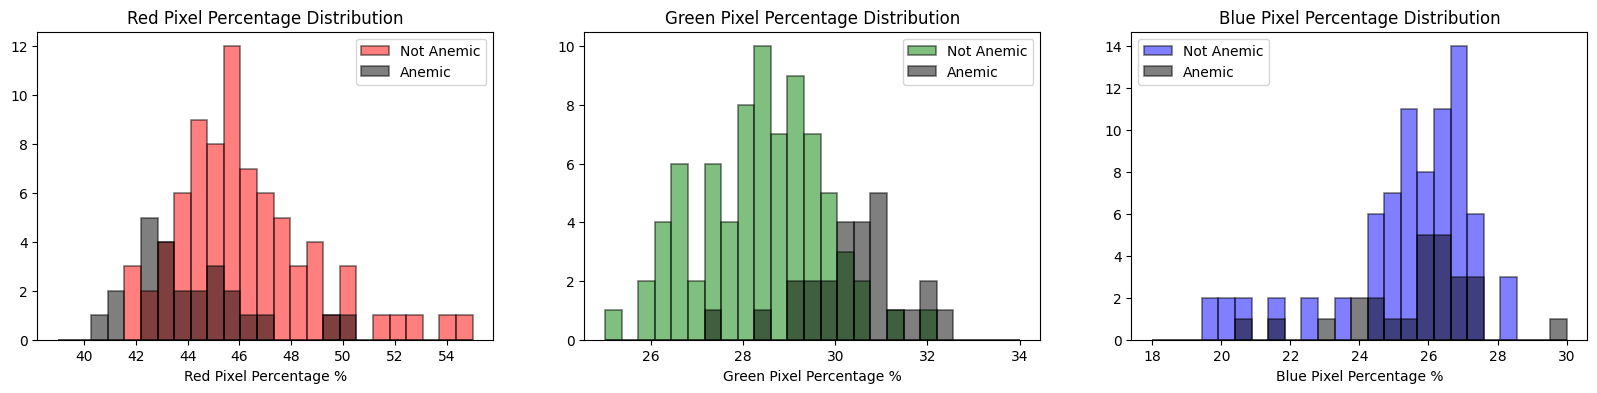

In [11]:
#We now create our histogram using the lists created.

fig, axs = plt.subplots(1, 3, figsize=(20, 4))

# Plot the histograms on separate subplots with transparency
axs[0].hist(red_no, bins=25, range=(39, 55), density=False, alpha=0.5, color='red', label='Not Anemic', edgecolor='black', linewidth=1.2)
axs[0].hist(red_yes, bins=25, range=(39, 55), density=False, alpha=0.5, color='black', label='Anemic', edgecolor='black', linewidth=1.2)
axs[0].set_title('Red Pixel Percentage Distribution')
axs[0].set_xlabel('Red Pixel Percentage %')
axs[0].legend()

axs[1].hist(green_no, bins=25, range=(25, 34), density=False, alpha=0.5, color='green', label='Not Anemic', edgecolor='black', linewidth=1.2)
axs[1].hist(green_yes, bins=25, range=(25, 34), density=False, alpha=0.5, color='black', label='Anemic', edgecolor='black', linewidth=1.2)
axs[1].set_title('Green Pixel Percentage Distribution')
axs[1].set_xlabel('Green Pixel Percentage %')
axs[1].legend()

axs[2].hist(blue_no, bins=25, range=(18, 30), density=False, alpha=0.5, color='blue', label='Not Anemic', edgecolor='black', linewidth=1.2)
axs[2].hist(blue_yes, bins=25, range=(18, 30), density=False, alpha=0.5, color='black', label='Anemic', edgecolor='black', linewidth=1.2)
axs[2].set_title('Blue Pixel Percentage Distribution')
axs[2].set_xlabel('Blue Pixel Percentage %')
axs[2].legend()

plt.show()

#Observe that the blue distribution is not striking from a merely visual standpoint. However, it appears that anemic patients have significantly higher 
#green percentages, and significantly lower red percentages. We will proceed with some inferential statistics to affirm this.

In [12]:
#Here we take the means and standard deviations of green pixel percentages of patients with and without anemia.

anemia_green = np.array(green_yes)
nonanemic_green = np.array(green_no)

mean_gre_anemic = anemia_green.mean()
mean_gre_not = nonanemic_green.mean()

stdv_anemic_gre = stat.stdev(anemia_green)
stdv_nonanemic_gre = stat.stdev(nonanemic_green)

print(mean_gre_anemic)
print(mean_gre_not)
print(stdv_anemic_gre)
print(stdv_nonanemic_gre)


30.39308076923077
28.369648717948714
1.1264500496761425
1.335157854643606


In [13]:
shapiro_gre_anemic = shapiro(anemia_green)
shapiro_gre_anemic
#this implies that the green percentages for the anemic population are normally distributed, since p>>.05

ShapiroResult(statistic=np.float64(0.9746357693303955), pvalue=np.float64(0.7448000022721138))

In [14]:
shapiro_gre_non = shapiro(nonanemic_green)
shapiro_gre_non
#this implies that the green percentages for the nonanemic population are normally distributed.

ShapiroResult(statistic=np.float64(0.9931849579231953), pvalue=np.float64(0.9561568705430448))

In [15]:
t_stat, p_value = ttest_ind(anemia_green, nonanemic_green, alternative = 'greater')
t_stat, p_value
#perfect!
#Since p<<<.05 and both sets are normal, we conclude that people with anemia have a higher green pixel percentage.

(np.float64(6.941936293138544), np.float64(1.8356747458055143e-10))

In [16]:
#Repeat for red.

anemia_red = np.array(red_yes)
nonanemic_red = np.array(red_no)

mean_red_anemic = anemia_red.mean()
mean_red_not = nonanemic_red.mean()

stdv_anemic_red = stat.stdev(anemia_red)
stdv_nonanemic_red = stat.stdev(nonanemic_red)

print(mean_red_anemic)
print(mean_red_not)
print(stdv_anemic_red)
print(stdv_nonanemic_red)

43.93872692307692
46.22599102564102
2.5542632078245484
2.677038984487127


In [17]:
shapiro_red_anemic = shapiro(anemia_red)
shapiro_red_anemic
#this implies that the red percentages for the anemic population are normally distributed.

ShapiroResult(statistic=np.float64(0.9601808234524517), pvalue=np.float64(0.3951046215000273))

In [18]:
shapiro_red_non = shapiro(nonanemic_red)
shapiro_red_non
#unfortunately, the result here implies the red percentages for the nonanemic population are not necessarily normally distributed.
#on the other hand, we visually observe there may be outliers. 

ShapiroResult(statistic=np.float64(0.9325554093463249), pvalue=np.float64(0.00047065864472325747))

In [19]:
#We can check for the possibility of outliers by filtering the nonanemic red array by a boolean index.
outlierstest = nonanemic_red[nonanemic_red > 50]
outlierstest

array([50.3562, 52.9108, 50.4976, 53.9113, 50.4801, 54.6478, 52.154 ,
       51.5802])

[array([52.9108, 53.9113, 54.6478, 52.154 ])]

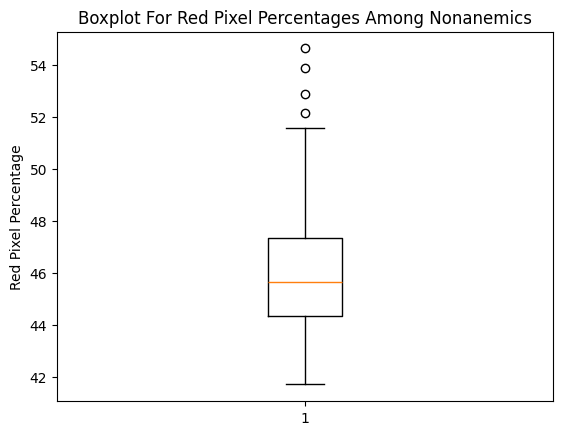

In [20]:
#Now, let's be precise and ensure these are actual outliers by making a boxplot and retrieving data from it.
B = plt.boxplot(nonanemic_red)
plt.title('Boxplot For Red Pixel Percentages Among Nonanemics')
plt.ylabel('Red Pixel Percentage')
outliers = [item.get_ydata() for item in B['fliers']]
outliers

In [21]:
#As we can see, the 4 values above are outliers. Let us remove them and repeat the shapiro test.
# Concatenate the arrays of outliers first.
outliers = np.concatenate(outliers)

# Convert outliers to a set to handle duplicates
outliers_set = set(outliers)

# Create a new array excluding outliers
new_nonanemic_red = np.array([value for value in nonanemic_red if value not in outliers_set])

In [22]:
#Let us repeat the normality test for the nonanemic red data with outliers removed.
new_shapiro_red_non = shapiro(new_nonanemic_red)
new_shapiro_red_non
#The data is normal!

ShapiroResult(statistic=np.float64(0.9772492732394025), pvalue=np.float64(0.20236833475028249))

In [23]:
t_stat, p_value = ttest_ind(anemia_red, new_nonanemic_red, alternative = 'less')
t_stat, p_value
#this implies that people with anemia have a lower red pixel percentage.


(np.float64(-3.710465952265096), np.float64(0.00017168333452023706))

In [24]:
mean_gre_anemic

np.float64(30.39308076923077)

In [25]:
#return the number of anemics with low green %s vs high green %s

threshold = mean_gre_anemic
low_green_anemic = [i for i in green_yes if i < threshold]
len(low_green_anemic)

12

In [26]:
high_green_anemic = [i for i in green_yes if i > threshold]
len(high_green_anemic)

14

In [27]:
mean_red_anemic

np.float64(43.93872692307692)

In [28]:
threshold2 = mean_red_anemic
low_red_anemic = [i for i in red_yes if i < threshold2]
len(low_red_anemic)

14

In [29]:
high_red_anemic = [i for i in red_yes if i > threshold2]
len(high_red_anemic)

12

Text(0.5, 1.0, 'Proportions of High vs Low Red Anemics')

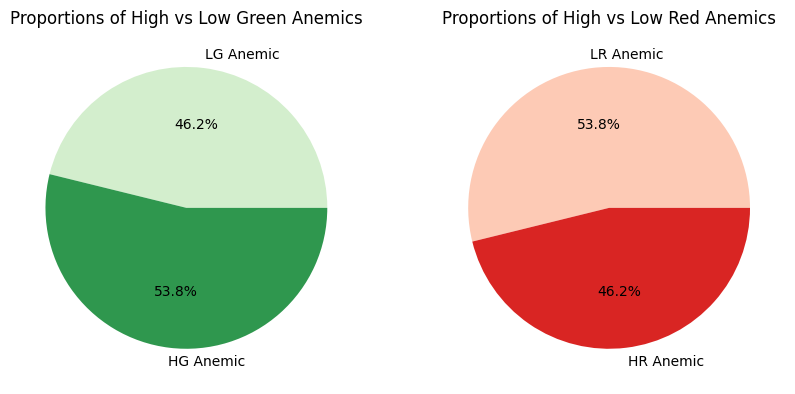

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) #ax1,ax2 refer to your two pies

# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

x_1 = [12, 14]
x_2 = [14, 12]

labels = ['LG Anemic', 'HG Anemic']
colors = plt.get_cmap('Greens')(np.linspace(0.2, 0.7, len(x_1)))
ax1.pie(x_1, labels = labels, colors=colors, radius=1, center=(1, 1),
       autopct = '%1.1f%%') #plot first pie
ax1.set_title('Proportions of High vs Low Green Anemics')


labels =  ['LR Anemic', 'HR Anemic']
colors2 = plt.get_cmap('Reds')(np.linspace(0.2, 0.7, len(x_2)))
ax2.pie(x_2,labels = labels,colors = colors2, radius=1, center=(4, 1), autopct = '%1.1f%%') #plot second pie
ax2.set_title('Proportions of High vs Low Red Anemics')